In [ ]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import time
import copy
import matplotlib.pyplot as plt
import os
import random

seed=42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Normalisation des images pour les modèles pré-entraînés PyTorch

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
image_directory = "/content/gdrive/MyDrive/GitHub/ProjetFromage/data_fromage"
dataset_full = datasets.ImageFolder(image_directory, data_transforms)

# split en train, val et test à partir de la liste complète
np.random.seed(42)
samples_train, samples_test = train_test_split(dataset_full.samples)
samples_train, samples_val = train_test_split(samples_train,test_size=0.2)

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 2288
Nombre d'images de val : 572
Nombre d'images de test : 954


In [ ]:
BATCH_SIZE = 16

# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test
dataset_train = datasets.ImageFolder(image_directory, data_transforms)
dataset_train.samples = samples_train
dataset_train.imgs = samples_train
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

dataset_val = datasets.ImageFolder(image_directory, data_transforms)
dataset_val.samples = samples_val
dataset_val.imgs = samples_val

dataset_test = datasets.ImageFolder(image_directory, data_transforms)
dataset_test.samples = samples_test
dataset_test.imgs = samples_test

torch.manual_seed(42)

In [ ]:
# détermination du nombre de classes
# vérification que les labels sont bien dans [0, nb_classes]
labels=[x[1] for x in samples_train]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
print("Apprentissage sur {} classes".format(nb_classes))

Apprentissage sur 43 classes


In [ ]:
# on définit le device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [ ]:
# on définit une fonction d'évaluation
def evaluate(model, dataset):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        
        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)

# fonction d'entraînement du modèle
PRINT_LOSS = False

def train_model(model, loader_train, data_val, optimizer, criterion, n_epochs=10, scheduler=None):
  
    since = time.time()
    best_acc=0
    best_model_wts = copy.deepcopy(model.state_dict())
    saved_acc=[]
    lrs=[]

    for epoch in range(n_epochs): 
        batch=0
        print("EPOCH % i" % epoch)
        for i, data in enumerate(loader_train):
            batch+=1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad() 
            outputs = model(inputs) 
            
            loss = criterion(outputs, labels) 
            if PRINT_LOSS:
                model.train(False)
                loss_val, accuracy = evaluate(model, data_val)
                model.train(True)
                print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))
            
            loss.backward() 
            optimizer.step() 
            lrs.append(optimizer.param_groups[0]["lr"])
            if scheduler:
              scheduler.step()
            #print(f'Batch {i} done')

        model.train(False)
        loss_val, accuracy = evaluate(model, data_val)
        saved_acc.append(accuracy)

        #early stopping
        if accuracy>best_acc:
          best_acc=accuracy
          best_model_wts = copy.deepcopy(model.state_dict())
        model.train(True)
        print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))

    plt.plot(lrs)
    model.load_state_dict(best_model_wts)
    return best_acc


Apprentissage en transfer learning : Scheduler = Multiplicative Scheduler ; Weight decay = 0
EPOCH  0
142 loss train: 2.7886	 val 0.1770	Acc (val): 38.1%
EPOCH  1
142 loss train: 2.7757	 val 0.1471	Acc (val): 50.2%
EPOCH  2
142 loss train: 1.8610	 val 0.1317	Acc (val): 53.1%
EPOCH  3
142 loss train: 1.6620	 val 0.1226	Acc (val): 58.7%
EPOCH  4
142 loss train: 1.9486	 val 0.1152	Acc (val): 60.3%
EPOCH  5
142 loss train: 1.5098	 val 0.1128	Acc (val): 59.8%
EPOCH  6
142 loss train: 1.7621	 val 0.1098	Acc (val): 61.0%
EPOCH  7
142 loss train: 1.6674	 val 0.1077	Acc (val): 61.2%
EPOCH  8
142 loss train: 1.7595	 val 0.1057	Acc (val): 60.8%
EPOCH  9
142 loss train: 1.1031	 val 0.1055	Acc (val): 62.1%
Best Acc Val = 0.6206293706293706

Apprentissage en transfer learning : Scheduler = Cyclic Scheduler ; Weight decay = 0
EPOCH  0
142 loss train: 3.2110	 val 0.2022	Acc (val): 24.7%
EPOCH  1
142 loss train: 3.0422	 val 0.1737	Acc (val): 43.9%
EPOCH  2
142 loss train: 2.2126	 val 0.1564	Acc (val): 

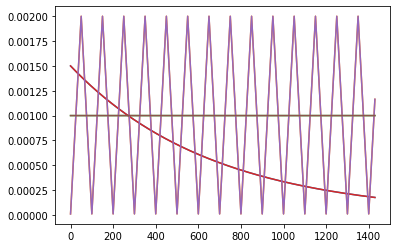

In [ ]:
#===== Transfer learning "simple" (sans fine tuning) =====

global_best_acc=0
best_param={}
best_net=models.mobilenet_v2(pretrained=True)

for weight_decay in [0, 0.0001]:
  for scheduler_name in ["Multiplicative Scheduler", "Cyclic Scheduler", "No Scheduler"]:
    
    my_net = models.mobilenet_v2(pretrained=True)

    for param in my_net.parameters():
        param.requires_grad = False

    my_net.classifier[1] = nn.Linear(in_features=my_net.classifier[1].in_features, out_features=nb_classes, bias=True)
    my_net.to(device) 
    my_net.train(True) 

    criterion = nn.CrossEntropyLoss()
    optimizer0 = optim.SGD(my_net.classifier[1].parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)
    optimizer1 = optim.SGD(my_net.classifier[1].parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)
    optimizer2 = optim.SGD(my_net.classifier[1].parameters(), lr=0.0015, momentum=0.9, weight_decay=weight_decay)
    
    dic_scheduler={"No Scheduler":[None, optimizer0]}
    scheduler1=optim.lr_scheduler.CyclicLR(optimizer1, base_lr=0.00001, max_lr=0.002,step_size_up=50,mode="triangular")
    dic_scheduler["Cyclic Scheduler"]=[scheduler1, optimizer1]
    lambda2 = lambda x: 0.9985 ** x
    scheduler2 = optim.lr_scheduler.LambdaLR(optimizer2, lr_lambda=lambda2)
    dic_scheduler["Multiplicative Scheduler"]=[scheduler2, optimizer2]

    scheduler=dic_scheduler[scheduler_name][0]
    optimizer=dic_scheduler[scheduler_name][1]

    print(f'Apprentissage en transfer learning : Scheduler = {scheduler_name} ; Weight decay = {weight_decay}')
    my_net.train(True)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    best_acc=train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10, scheduler=scheduler)
    print(f'Best Acc Val = {best_acc}\n')
    if best_acc>global_best_acc:
      global_best_acc=best_acc
      best_param={"Weight decay":weight_decay, "Scheduler":scheduler_name}
      best_net=my_net

print(">>> Best param :")
for key, item in best_param.items():
  print(f'{key} = {item}')

# évaluation
best_net.train(False)
loss, accuracy = evaluate(best_net, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

Apprentissage en transfer learning : Scheduler = Multiplicative Scheduler ; Weight decay = 0
EPOCH  0
142 loss train: 1.6280	 val 0.1113	Acc (val): 57.2%
EPOCH  1
142 loss train: 1.8255	 val 0.0765	Acc (val): 67.5%
EPOCH  2
142 loss train: 0.8049	 val 0.0665	Acc (val): 70.8%
EPOCH  3
142 loss train: 0.6535	 val 0.0594	Acc (val): 75.5%
EPOCH  4
142 loss train: 0.4498	 val 0.0539	Acc (val): 78.3%
EPOCH  5
142 loss train: 0.2030	 val 0.0527	Acc (val): 77.8%
EPOCH  6
142 loss train: 0.2444	 val 0.0516	Acc (val): 78.5%
EPOCH  7
142 loss train: 0.3932	 val 0.0511	Acc (val): 78.7%
EPOCH  8
142 loss train: 0.1727	 val 0.0504	Acc (val): 79.9%
EPOCH  9
142 loss train: 0.0789	 val 0.0511	Acc (val): 79.2%
Best Acc Val = 0.798951048951049

Apprentissage en transfer learning : Scheduler = Cyclic Scheduler ; Weight decay = 0
EPOCH  0
142 loss train: 2.5158	 val 0.1533	Acc (val): 49.0%
EPOCH  1
142 loss train: 2.1034	 val 0.1029	Acc (val): 60.7%
EPOCH  2
142 loss train: 1.0172	 val 0.0844	Acc (val): 6

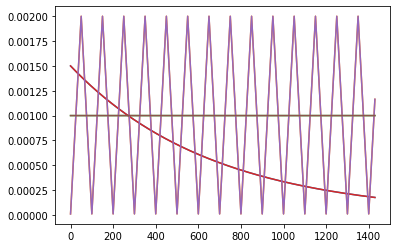

In [ ]:
torch.cuda.empty_cache()

#===== Fine tuning =====

global_best_acc=0
best_param={}
best_net_ft=models.mobilenet_v2(pretrained=True)

for weight_decay in [0, 0.0001]:
  for scheduler_name in ["Multiplicative Scheduler", "Cyclic Scheduler", "No Scheduler"]:
    # on réinitialise MobileNet
    my_net_ft = models.mobilenet_v2(pretrained=True)
    my_net_ft.classifier[1] = nn.Linear(in_features=my_net_ft.classifier[1].in_features, out_features=nb_classes, bias=True)
    my_net_ft.to(device)

    # cette fois on veut updater tous les paramètres
    criterion = nn.CrossEntropyLoss()
    optimizer0 = optim.SGD(my_net_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)
    optimizer1 = optim.SGD(my_net_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)
    optimizer2 = optim.SGD(my_net_ft.parameters(), lr=0.0015, momentum=0.9, weight_decay=weight_decay)
    
    dic_scheduler={"No Scheduler":[None, optimizer0]}
    scheduler1=optim.lr_scheduler.CyclicLR(optimizer1, base_lr=0.00001, max_lr=0.002,step_size_up=50,mode="triangular")
    dic_scheduler["Cyclic Scheduler"]=[scheduler1, optimizer1]
    lambda2 = lambda x: 0.9985 ** x
    scheduler2 = optim.lr_scheduler.LambdaLR(optimizer2, lr_lambda=lambda2)
    dic_scheduler["Multiplicative Scheduler"]=[scheduler2, optimizer2]

    scheduler=dic_scheduler[scheduler_name][0]
    optimizer=dic_scheduler[scheduler_name][1]

    # on ré-entraîne
    print(f'Apprentissage en transfer learning : Scheduler = {scheduler_name} ; Weight decay = {weight_decay}')
    my_net_ft.train(True)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    best_acc=train_model(my_net_ft, loader_train, dataset_val, optimizer, criterion, n_epochs=10, scheduler=scheduler)
    print(f'Best Acc Val = {best_acc}\n')
    if best_acc>global_best_acc:
      global_best_acc=best_acc
      best_param={"Weight decay":weight_decay, "Scheduler":scheduler_name}
      best_net_ft=my_net_ft

print(">>> Best param :")
for key, item in best_param.items():
  print(f'{key} = {item}')

# on ré-évalue les performances
best_net_ft.train(False)
loss, accuracy = evaluate(best_net_ft, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))